In [1]:
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [2]:
import pandas as pd

file_name = "household_power_consumption.txt"  # mets ici le vrai nom

df = pd.read_csv(
    file_name,
    sep=";",                 # séparateur ;
    decimal=".",             # séparateur décimal .
    na_values="?",           # dans ce dataset, les valeurs manquantes sont "?"
)

In [3]:
df.head()
# Date Time sont séparées, nous allons les combiner, pour qu'elles soit plus adaptée au fonctionnalités predefinies de panda

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
# Combiner Date + Time en une seule colonne datetime
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

# Mettre datetime en index pour rapidité
df = df.set_index("datetime")

In [5]:
df.head()
# La combinaison à terminée

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
# Nous allons vérifier si tous les champs sont remplies
df.isna().sum()
# Remarque d'absence de 25979 valeurs pour quelques colonnes
# Nosu décidons de les supprimer car nous avons plus de 2M lignes, et 25979 fait 1% de la taille du Dataset

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [7]:
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Nous supprimons les lignes où les mesures sont NaN
df = df.dropna(subset=num_cols)

df.isna().sum()
# Maintenant, nous n'avons aucune ligne avec valeur manquante


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [8]:
len(df)
# 2 075 259 - 25 979 = 2 049 280

2049280

In [9]:
# Dans la phase de netoyyage, nous allons nous assurer que tous les champs chiffres sont numériques
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[num_cols].dtypes  # pour vérifier que c'est bien float64

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [10]:
# Global_active_power est en kW mesuré chaque minute.
# Pour obtenir l'énergie consommée pendant chaque minute (en kWh),
# nous multiplions par la durée en heures : 1 minute = 1/60 heure → donc division par 60.
df["energy_kwh"] = df["Global_active_power"] / 60.0

In [11]:
#   - Pour les puissances et la tension, nous prenons la moyenne quotidienne.
#   - Pour les compteurs d'énergie (sub_metering_1/2/3) et energy_kwh, nous faisons la somme sur la journée.
# Création d'un nouveau Dataset Daily, qui match bien la forme de l'API consommée
daily = df.resample("D").agg({
    "Global_active_power": "mean",      # Puissance active moyenne (kW) par jour
    "Global_reactive_power": "mean",    # Puissance réactive moyenne (kVAR) par jour
    "Voltage": "mean",                  # Tension moyenne (V)
    "Global_intensity": "mean",         # Intensité moyenne (A)
    "Sub_metering_1": "sum",            # Énergie journalière (Wh) sur le compteur 1
    "Sub_metering_2": "sum",            # Énergie journalière (Wh) sur le compteur 2
    "Sub_metering_3": "sum",            # Énergie journalière (Wh) sur le compteur 3
    "energy_kwh": "sum"                 # Énergie totale journalière (kWh) = variable cible principale
})


In [12]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh
datetime,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933
2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667
2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433
2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800


In [13]:
# 4) Nous renommons, juste comme bonne pratique la colonne datetime en date, car elle ne comporte pas le time
daily["date"] = daily.index
daily = daily.reset_index(drop=True)

In [14]:
len(daily)
print(daily.columns.tolist())
# 1442 lignes, pour notre objectif tracée, relation de la météo journalière et la type de jour ( week end, jours ferié , jour normal )

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'energy_kwh', 'date']


In [15]:
# Jour de la semaine (0 = lundi, 6 = dimanche)
daily["jour_semaine"] = daily["date"].dt.dayofweek

In [16]:
# Nom du jour (pour les graphiques)
daily["jour_nom"] = daily["date"].dt.day_name()

In [17]:
# Week-end : samedi (5) et dimanche (6)
daily["is_weekend"] = daily["jour_semaine"].isin([5, 6])

In [18]:
!pip install holidays
import pandas as pd
import holidays
# Jours fériés français (2006–2010)
fr_holidays = holidays.France(years=[2006, 2007, 2008, 2009, 2010])
daily["is_holiday"] = daily["date"].apply(lambda d: d in fr_holidays)

In [19]:
daily[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]].head(15)
# Maintenant, nous avons pour chaque ligne, est ce que c'est un week end ?
# ou c'est un jours ferié,
# les jours normaux sont les jours dont weekend = false et holyday = false


,date,jour_nom,is_weekend,is_holiday,energy_kwh
0,2006-12-16,Saturday,True,False,20.152933
1,2006-12-17,Sunday,True,False,56.507667
2,2006-12-18,Monday,False,False,36.730433
3,2006-12-19,Tuesday,False,False,27.769900
4,2006-12-20,Wednesday,False,False,37.095800
5,2006-12-21,Thursday,False,False,28.610400
6,2006-12-22,Friday,False,False,39.022300
7,2006-12-23,Saturday,True,False,79.556433
8,2006-12-24,Sunday,True,False,42.500200
9,2006-12-25,Monday,False,True,45.718667


In [20]:
daily.nlargest(10, "energy_kwh")[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]]
# Dejà une remarque avant même d'aller à la météo, les TOP 1 sont generalement des week ends en hiver

,date,jour_nom,is_weekend,is_holiday,energy_kwh
7,2006-12-23,Saturday,True,False,79.556433
49,2007-02-03,Saturday,True,False,67.162033
10,2006-12-26,Tuesday,False,False,65.568500
64,2007-02-18,Sunday,True,False,63.829367
50,2007-02-04,Sunday,True,False,59.932333
57,2007-02-11,Sunday,True,False,59.520467
105,2007-03-31,Saturday,True,False,58.491833
15,2006-12-31,Sunday,True,False,58.236600
85,2007-03-11,Sunday,True,False,58.010600
36,2007-01-21,Sunday,True,False,56.787700


In [21]:
# Mois numérique (1 = janvier, ..., 12 = décembre)
daily["mois"] = daily["date"].dt.month

# Nom du mois (Janvier, Février, ...)
daily["mois_nom"] = daily["date"].dt.month_name()

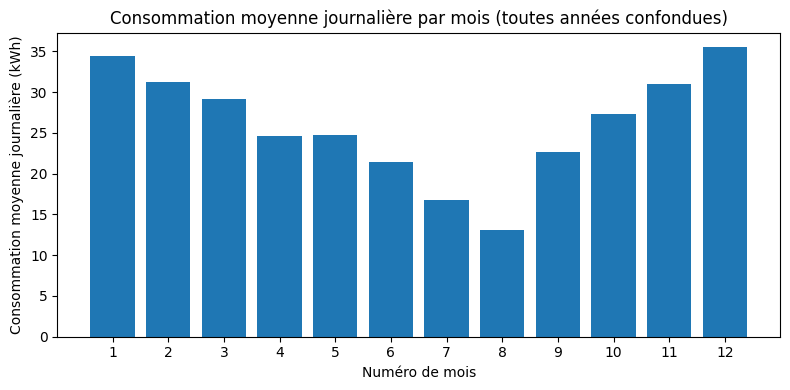

In [22]:
# Affichage d'un graphe pour indiquer la relation entre le mois ( froid ou chaud ) et la consommation
import matplotlib.pyplot as plt

moyenne_par_mois = (
    daily.groupby("mois")[["energy_kwh"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.bar(moyenne_par_mois["mois"], moyenne_par_mois["energy_kwh"])
plt.xticks(range(1, 13))
plt.xlabel("Numéro de mois")
plt.ylabel("Consommation moyenne journalière (kWh)")
plt.title("Consommation moyenne journalière par mois (toutes années confondues)")
plt.tight_layout()
plt.show()

In [23]:
import requests
import pandas as pd


# Période couverte par vos données, pour passer à l'API, en relation avec le tableau comme plage
date_min = daily["date"].min().strftime("%Y-%m-%d")
date_max = daily["date"].max().strftime("%Y-%m-%d")

# Coordonnées de Sceaux (France) selons le site web https://www.gps-longitude-latitude.net/
lat, lon = 48.78, 2.29
# Liste des données que nous voulons
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": date_min,
    "end_date": date_max,
    "daily": [
        "temperature_2m_mean",
        "temperature_2m_min",
        "temperature_2m_max",
        "precipitation_sum",
        "daylight_duration",
        "sunshine_duration",
    ],
    "timezone": "Europe/Paris",
}
# Consommation de l'API
resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# Création du DataFrame météo,
weather = pd.DataFrame(data["daily"])
# Convertir en Date
weather["date"] = pd.to_datetime(weather["time"])
# Suppression de colone time, elle est imposé par l'API, obligé de la notoyé ici
weather = weather.drop(columns=["time"])

weather.head()

,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,date
0,6.2,3.3,8.4,3.8,29825.21,0.00,2006-12-16
1,3.0,-0.2,7.1,0.0,29797.73,19535.07,2006-12-17
2,3.1,1.2,5.2,0.9,29775.72,7489.45,2006-12-18
3,1.8,0.6,4.2,0.0,29759.19,24686.46,2006-12-19
4,1.2,-0.8,4.8,0.0,29748.15,24821.37,2006-12-20


In [24]:
# Etape importante, le Merge entre API et Dataset, cette ligne doit petre executée une seule fois sinon nous allons avoir 2 colonnes
# et pd change le nom des colonnes automatiquement, avec _x et _y
daily = daily.merge(weather, on="date", how="left")

In [25]:
# Vérification du forme du tableau
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date,jour_semaine,...,is_weekend,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration
0,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,2006-12-16,5,...,True,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00
1,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,2006-12-17,6,...,True,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07
2,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,2006-12-18,0,...,False,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45
3,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,2006-12-19,1,...,False,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46
4,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2006-12-20,2,...,False,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37


In [26]:
# Convertir le nombre de secondes entre lever et coucher de solein en heures
daily["daylight_hours"] = daily["daylight_duration"] / 3600.0

In [27]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date,jour_semaine,...,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,daylight_hours
0,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,2006-12-16,5,...,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00,8.284781
1,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,2006-12-17,6,...,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07,8.277147
2,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,2006-12-18,0,...,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45,8.271033
3,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,2006-12-19,1,...,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46,8.266442
4,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2006-12-20,2,...,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37,8.263375


/tmp/ipython-input-2521318056.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby("temp_bin")["energy_kwh"]


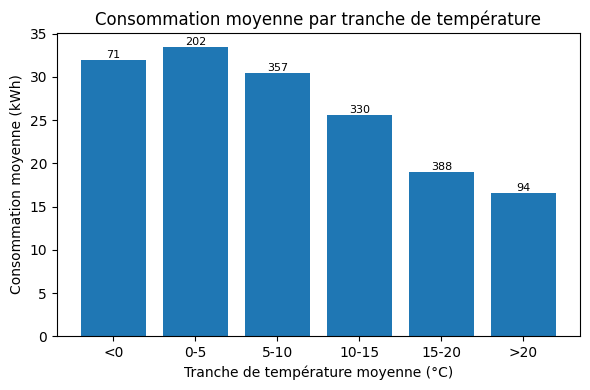

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Tranches de température
bins = [-10, 0, 5, 10, 15, 20, 30]
labels = ["<0", "0-5", "5-10", "10-15", "15-20", ">20"]
daily["temp_bin"] = pd.cut(daily["temperature_2m_mean"], bins=bins, labels=labels, include_lowest=True)

# Moyenne + nombre de jours par tranche
stats_par_bin = (
    daily.groupby("temp_bin")["energy_kwh"]
    .agg(["mean", "count"])
    .reset_index()
)

plt.figure(figsize=(6, 4))
bars = plt.bar(stats_par_bin["temp_bin"], stats_par_bin["mean"])

plt.xlabel("Tranche de température moyenne (°C)")
plt.ylabel("Consommation moyenne (kWh)")
plt.title("Consommation moyenne par tranche de température")

# Ajouter le nombre d'éléments au-dessus de chaque barre
for bar, n in zip(bars, stats_par_bin["count"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(n),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()
# ça nous aide encore à  avoir une idée de relation entre "Fait froid" et "consommation".
# nous avons ajouté le nombre audesus de chaque barre juste oiyr argumenter Pk la consommation
# dans la situation <0 est plus petite que entre 0 et 5

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
features = [
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "precipitation_sum",
    "daylight_hours",
    "sunshine_duration",
    "jour_semaine",
    "is_weekend",
    "is_holiday",
    "mois",
]

X = daily[features].copy()
y = daily["energy_kwh"]

# Séparation train / test (sans mélanger, pour garder l'ordre temporel)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Modèle
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (kWh) :", round(rmse, 2))
print("R²         :", round(r2, 3))

# Nous remarquons que notre prédiction n'est pas performante
# Nosu allons essayer d'ajouter d'autre variables à notre DataSet
# Seuil confort pour avoir une relation linéaire entre Difference et consommation
# Traitement cyclique du mois 1 et 12
# Consommation le même jour il ya uen semaine ( pour capter les habitudes )

RMSE (kWh) : 7.31
R²         : 0.23


In [30]:
import numpy as np

# --- Degrés Jours Unifiés (DJU) - seuil 18°C ---
seuil_confort = 18
daily["DJU"] = (seuil_confort - daily["temperature_2m_mean"]).clip(lower=0)

# --- Variables cycliques du mois (décembre proche de janvier) ---
daily["sin_mois"] = np.sin(2 * np.pi * daily["mois"] / 12)
daily["cos_mois"] = np.cos(2 * np.pi * daily["mois"] / 12)

# --- Lag 7 : consommation le même jour de la semaine dernière ---
daily["energy_kwh_lag7"] = daily["energy_kwh"].shift(7)

# Supprimer les lignes avec NaN (les 7 premiers jours n'ont pas de lag7)
daily = daily.dropna(subset=["energy_kwh_lag7"]).copy()

In [31]:
features = [
    "DJU",
    "daylight_hours",
    "sin_mois",
    "cos_mois",
    "is_weekend",
    "is_holiday",
    "energy_kwh_lag7",
]

X = daily[features].copy()
y = daily["energy_kwh"]

# Séparation Train / Test (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Évaluation
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (kWh) :", round(rmse, 2))
print("R²         :", round(r2, 3))

RMSE (kWh) : 7.5
R²         : 0.191


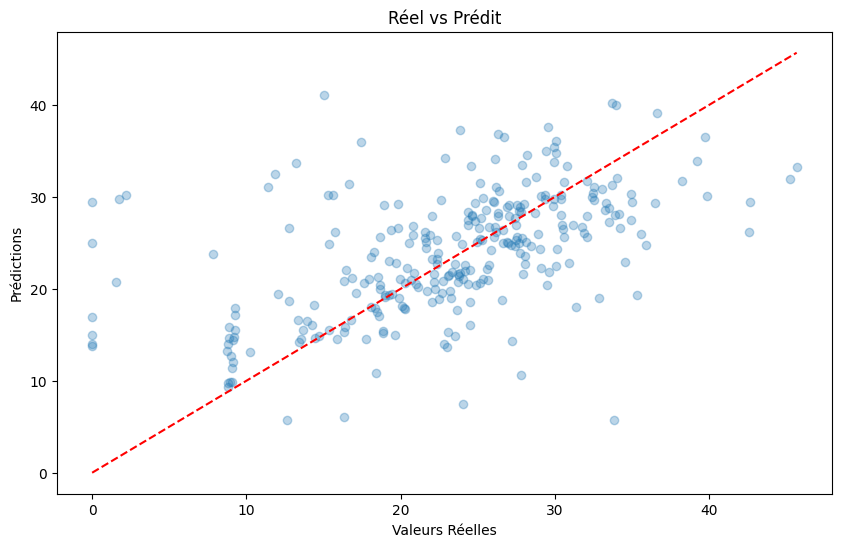

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Réel vs Prédit')
plt.show()
# Les valeurs reels ne sont pas vraiment lnéaire, ce qui montre qu'il ya autres variables en relation avec la consommation
# Nous allons essayer d'eliminer les lignes avec une valeurs de consommation < 4Kwh et > 33kwh
# La moyenne de consommation en france est 13Kwh

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Filtrer : garder seulement les jours où energy_kwh > 0.5 ---
mask = daily["energy_kwh"] > 4
daily_filtre = daily.loc[mask].copy()

print("Nombre de jours avant filtre :", len(daily))
print("Nombre de jours après filtre (energy_kwh > 4) :", len(daily_filtre))

# --- X et y sur le jeu filtré ---
features = [
    "DJU",
    "daylight_hours",
    "sin_mois",
    "cos_mois",
    "is_weekend",
    "is_holiday",
    "energy_kwh_lag7"
]

X_f = daily_filtre[features].copy()
y_f = daily_filtre["energy_kwh"]

# --- Train / Test (ordre temporel) ---
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, test_size=0.2, shuffle=False
)
# --- Entraînement ---
rf_f = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_f.fit(X_train_f, y_train_f)

# --- Prédiction ---
y_pred_f = rf_f.predict(X_test_f)

# --- RECALCUL DES MÉTRIQUES (L'étape manquante) ---
rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
mae_f = mean_absolute_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

# --- Affichage ---
print("--- Résultats après ajout de Lag1 ---")
print("RMSE (kWh) :", round(rmse_f, 2))
print("MAE (kWh)  :", round(mae_f, 2))
print("R²         :", round(r2_f, 3))

# Amélioration du R² et du RMSE

Nombre de jours avant filtre : 1435
Nombre de jours après filtre (energy_kwh > 4) : 1421
--- Résultats après ajout de Lag1 ---
RMSE (kWh) : 6.6
MAE (kWh)  : 4.78
R²         : 0.243


In [34]:
import pandas as pd

# 1. On crée un DataFrame spécifique pour les résultats du test
# On utilise .index pour garder la correspondance avec X_test_f
df_res = X_test_f.copy()
df_res['y_test'] = y_test_f.values
df_res['y_pred'] = y_pred_f
df_res['erreur'] = df_res['y_test'] - df_res['y_pred']
df_res['erreur_abs'] = df_res['erreur'].abs()

# 2. On trie par l'erreur absolue pour voir les plus gros écarts
top_20_err = df_res.sort_values(by='erreur_abs', ascending=False).head(20)

# 3. Affichage propre (on retire erreur_abs de l'affichage pour plus de clarté)
print("Top 20 des plus grosses erreurs (Jeu Filtré > 4 kWh) :")
print(top_20_err.drop(columns=['erreur_abs']).to_string())

Top 20 des plus grosses erreurs (Jeu Filtré > 4 kWh) :
       DJU  daylight_hours      sin_mois      cos_mois  is_weekend  is_holiday  energy_kwh_lag7     y_test     y_pred     erreur
1350   0.0       13.722336 -8.660254e-01 -5.000000e-01       False       False         0.000000  33.844167   5.150841  28.693326
1436  12.2        8.936978 -5.000000e-01  8.660254e-01        True       False        33.973200  15.015167  43.007026 -27.991859
1174  14.3       11.194506  1.000000e+00  6.123234e-17       False       False        31.336733  11.381333  31.255396 -19.874063
1176  15.7       11.312433  1.000000e+00  6.123234e-17        True       False        29.417600  13.245200  32.839240 -19.594040
1401  11.4       10.740428 -8.660254e-01  5.000000e-01        True       False        33.315067  17.456367  35.817848 -18.361481
1170  10.0       10.957164  8.660254e-01  5.000000e-01        True       False        45.671900  11.861100  30.190160 -18.329060
1419   3.1        9.742783 -5.000000e-01  

In [35]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

# --- Données : X = variables, y = energy_kwh (sur daily_filtre ou daily) ---
# Liste de toutes les variables candidates (adapte selon tes colonnes)
candidates = [
    "DJU", "daylight_hours", "sunshine_duration",
    "sin_mois", "cos_mois", "mois",
    "temperature_2m_mean", "temperature_2m_min", "temperature_2m_max",
    "precipitation_sum",
    "jour_semaine", "is_weekend", "is_holiday",
    "energy_kwh_lag1",
]
# Garder seulement les colonnes qui existent
candidates = [c for c in candidates if c in daily_filtre.columns]
X = daily_filtre[candidates].copy()
y = daily_filtre["energy_kwh"]

# Supprimer les lignes avec NaN (ex. lag manquant)
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]

# --- Méthode 1 : SelectKBest (univarié, corrélation avec y) ---
k_best = min(10, X.shape[1])  # garder au plus 10 features
selector_k = SelectKBest(score_func=f_regression, k=k_best)
selector_k.fit(X, y)
scores_k = pd.Series(selector_k.scores_, index=X.columns).sort_values(ascending=False)
selected_k = selector_k.get_feature_names_out(X.columns).tolist()
print("--- SelectKBest (top", k_best, ") ---")
print(scores_k.round(2))
print("Sélectionnées :", selected_k)

# --- Méthode 2 : Importance Random Forest ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n--- Importance (Random Forest) ---")
print(importances.round(4))
# Garder les features dont l'importance est au-dessus d'un seuil (ex. 0.02)
seuil = 0.02
selected_rf = importances[importances >= seuil].index.tolist()
if len(selected_rf) < 2:
    selected_rf = importances.head(5).index.tolist()
print("Sélectionnées (importance >= ", seuil, ") :", selected_rf)

# --- Méthode 3 : Intersection ou union des deux (recommandé : union ou seulement RF) ---
features_auto = list(dict.fromkeys(selected_rf + selected_k))[:12]  # union, max 12
print("\n--- Features retenues (automatique) ---")
print(features_auto)

--- SelectKBest (top 10 ) ---
temperature_2m_max     613.33
daylight_hours         612.71
temperature_2m_mean    610.27
DJU                    597.30
temperature_2m_min     527.88
cos_mois               526.23
sunshine_duration      198.05
sin_mois               139.94
is_weekend              68.74
jour_semaine            41.02
mois                    11.45
is_holiday               0.03
precipitation_sum        0.00
dtype: float64
Sélectionnées : ['DJU', 'daylight_hours', 'sunshine_duration', 'sin_mois', 'cos_mois', 'temperature_2m_mean', 'temperature_2m_min', 'temperature_2m_max', 'jour_semaine', 'is_weekend']

--- Importance (Random Forest) ---
temperature_2m_max     0.2358
daylight_hours         0.2097
temperature_2m_min     0.0811
sunshine_duration      0.0754
DJU                    0.0751
temperature_2m_mean    0.0695
cos_mois               0.0583
jour_semaine           0.0527
precipitation_sum      0.0452
is_weekend             0.0393
mois                   0.0283
sin_mois       

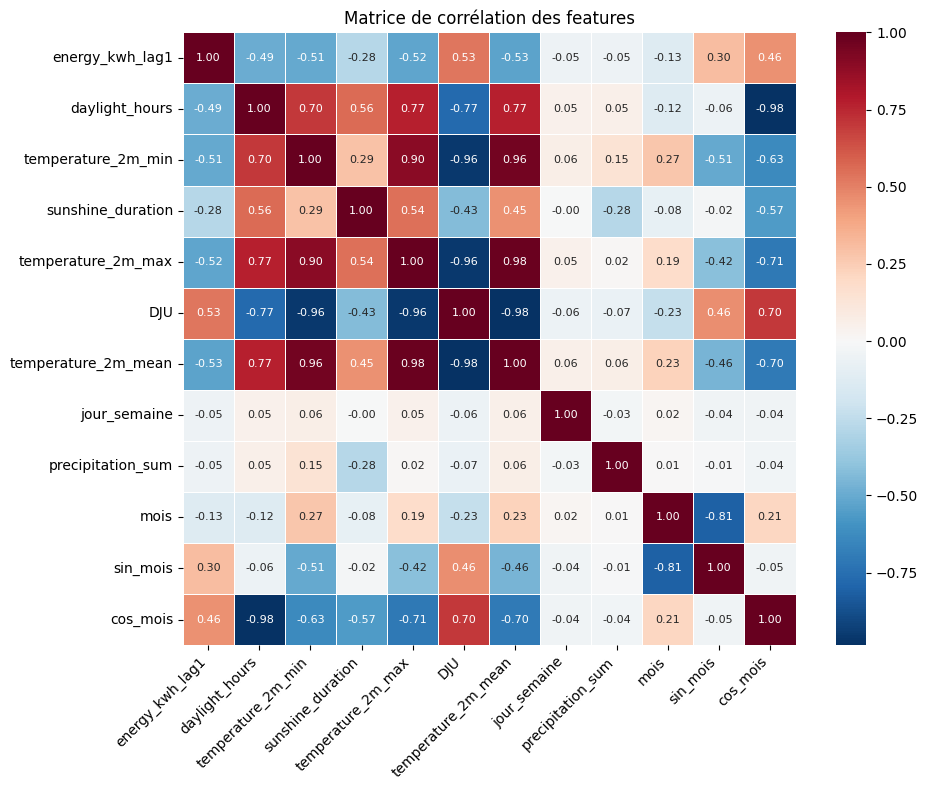

In [42]:
# =============================================================================
# Matrice de corrélation des features (même liste que pour le modèle)
# Placer cette cellule à côté de celle qui définit le top 10 / les features.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Matrice de corrélation sur les features
corr = daily_filtre[features].corr()

# Heatmap (seaborn si disponible, sinon matplotlib)
try:
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                square=True, linewidths=0.5, ax=ax,
                annot_kws={"size": 8})
    ax.set_title("Matrice de corrélation des features")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except ImportError:
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
    ax.set_xticks(range(len(features)))
    ax.set_yticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45, ha="right")
    ax.set_yticklabels(features)
    for i in range(len(features)):
        for j in range(len(features)):
            ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)
    plt.colorbar(im, ax=ax, label="Corrélation")
    ax.set_title("Matrice de corrélation des features")
    plt.tight_layout()
    plt.show()

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1) D'abord ajouter le lag-1 dans daily
daily["energy_kwh_lag1"] = daily["energy_kwh"].shift(1)

# 2) Ensuite filtrer (mask sur energy_kwh) et supprimer la ligne sans lag1
mask = (daily["energy_kwh"] > 4) & (daily["energy_kwh"] <= 33)
daily_filtre = daily.loc[mask].copy()
daily_filtre = daily_filtre.dropna(subset=["energy_kwh_lag1"])

features = ['energy_kwh_lag1',
            'daylight_hours',
            'temperature_2m_min',
            'sunshine_duration',
            'temperature_2m_max',
            'DJU',
            'temperature_2m_mean',
            'jour_semaine',
            'precipitation_sum',
            'mois',
            'sin_mois',
            'cos_mois']

X_f = daily_filtre[features].copy()
y_f = daily_filtre["energy_kwh"]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, test_size=0.1, shuffle=False
)

rf_f = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_f.fit(X_train_f, y_train_f)

y_pred_f = rf_f.predict(X_test_f)
rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
mae_f = mean_absolute_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

print("Nombre de jours (energy_kwh > 4 et <= 33) :", len(daily_filtre))
print("RMSE (kWh) :", round(rmse_f, 2))
print("MAE (kWh)  :", round(mae_f, 2))
print("R²         :", round(r2_f, 3))
# Amélioration du R² et du RMSE

Nombre de jours (energy_kwh > 4 et <= 33) : 1122
RMSE (kWh) : 4.14
MAE (kWh)  : 3.21
R²         : 0.658


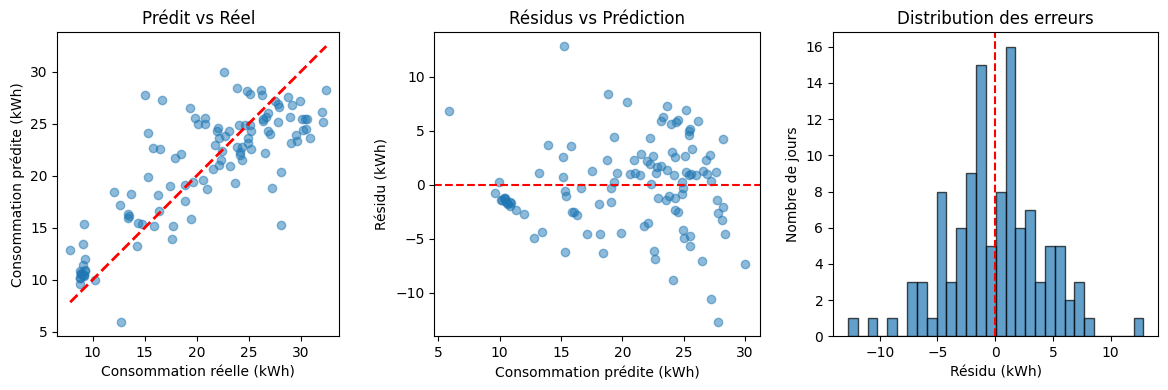

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 1. Prédit vs Réel
axes[0].scatter(y_test_f, y_pred_f, alpha=0.5)
axes[0].plot([y_test_f.min(), y_test_f.max()], [y_test_f.min(), y_test_f.max()], "r--", lw=2)
axes[0].set_xlabel("Consommation réelle (kWh)")
axes[0].set_ylabel("Consommation prédite (kWh)")
axes[0].set_title("Prédit vs Réel")
axes[0].set_aspect("equal")

# 2. Résidus vs Prédiction
residus = y_test_f.values - y_pred_f
axes[1].scatter(y_pred_f, residus, alpha=0.5)
axes[1].axhline(0, color="r", linestyle="--")
axes[1].set_xlabel("Consommation prédite (kWh)")
axes[1].set_ylabel("Résidu (kWh)")
axes[1].set_title("Résidus vs Prédiction")

# 3. Distribution des erreurs
axes[2].hist(residus, bins=30, edgecolor="black", alpha=0.7)
axes[2].axvline(0, color="r", linestyle="--")
axes[2].set_xlabel("Résidu (kWh)")
axes[2].set_ylabel("Nombre de jours")
axes[2].set_title("Distribution des erreurs")

plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import numpy as np
import requests
import holidays

# --- 1. Dernière date et consommations réelles (pour le bootstrap lag-1) ---
daily_filtre["date"] = pd.to_datetime(daily_filtre["date"]).dt.normalize()
last_date = daily_filtre["date"].max()
last_consumption = daily_filtre.set_index("date")["energy_kwh"]

# --- 2. Météo prévue : API Open-Meteo Forecast (7 jours) ---
lat, lon = 48.78, 2.29
url_forecast = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": lat,
    "longitude": lon,
    "daily": [
        "temperature_2m_mean",
        "temperature_2m_min",
        "temperature_2m_max",
        "daylight_duration",
        "sunshine_duration",
        "precipitation_sum",
    ],
    "timezone": "Europe/Paris",
    "forecast_days": 7,
}
resp = requests.get(url_forecast, params=params)
resp.raise_for_status()
data_f = resp.json()

# --- 3. Dates et météo : directement depuis l'API ---
weather_week = pd.DataFrame(data_f["daily"])
weather_week["date"] = pd.to_datetime(weather_week["time"])
weather_week["daylight_hours"] = weather_week["daylight_duration"] / 3600

# --- 4. Variables calendrier et DJU (mêmes noms que à l'entraînement) ---
df_week = weather_week[
    ["date", "temperature_2m_mean", "temperature_2m_min", "temperature_2m_max",
     "daylight_hours", "sunshine_duration", "precipitation_sum"]
].copy()
df_week["mois"] = df_week["date"].dt.month
df_week["jour_semaine"] = df_week["date"].dt.dayofweek
df_week["DJU"] = (18 - df_week["temperature_2m_mean"]).clip(lower=0)
df_week["sin_mois"] = np.sin(2 * np.pi * df_week["mois"] / 12)
df_week["cos_mois"] = np.cos(2 * np.pi * df_week["mois"] / 12)

# --- 5. Même liste de features qu'à l'entraînement (ordre identique) ---
features = [
    "energy_kwh_lag1", "daylight_hours", "temperature_2m_min", "sunshine_duration",
    "temperature_2m_max", "DJU", "temperature_2m_mean", "jour_semaine",
    "precipitation_sum", "mois", "sin_mois", "cos_mois",
]
preds_week = []
lag1 = float(last_consumption.iloc[-1])

for i in range(len(df_week)):
    row = df_week.iloc[i]
    if i > 0:
        lag1 = preds_week[-1]

    X_i = pd.DataFrame([{
        "energy_kwh_lag1": lag1,
        "daylight_hours": row["daylight_hours"],
        "temperature_2m_min": row["temperature_2m_min"],
        "sunshine_duration": row["sunshine_duration"],
        "temperature_2m_max": row["temperature_2m_max"],
        "DJU": row["DJU"],
        "temperature_2m_mean": row["temperature_2m_mean"],
        "jour_semaine": row["jour_semaine"],
        "precipitation_sum": row["precipitation_sum"],
        "mois": row["mois"],
        "sin_mois": row["sin_mois"],
        "cos_mois": row["cos_mois"],
    }])
    pred_i = rf_f.predict(X_i[features])[0]
    preds_week.append(pred_i)

df_week["energy_kwh_pred"] = preds_week

# --- 6. Affichage ---
df_week["date_affichage"] = df_week["date"].dt.strftime("%Y-%m-%d")
print("Prédictions pour les 7 prochains jours (dates API forecast) :")
print(df_week[["date_affichage", "energy_kwh_pred"]].to_string(index=False))

moyenne_semaine = df_week["energy_kwh_pred"].mean()
somme_semaine = df_week["energy_kwh_pred"].sum()
print("\nMoyenne de consommation sur la semaine (kWh/jour) :", round(moyenne_semaine, 2))
print("Consommation totale sur la semaine (kWh) :", round(somme_semaine, 2))

Prédictions pour les 7 prochains jours (dates API forecast) :
date_affichage  energy_kwh_pred
    2026-01-30        28.285800
    2026-01-31        28.428221
    2026-02-01        26.205374
    2026-02-02        25.154498
    2026-02-03        26.983321
    2026-02-04        28.388747
    2026-02-05        28.611688

Moyenne de consommation sur la semaine (kWh/jour) : 27.44
Consommation totale sur la semaine (kWh) : 192.06


**GBOOST**

In [39]:
# =============================================================================
# CELLULE UNIQUE : Gradient Boosting (GBoost) autonome
# À exécuter après la fusion (daily = daily.merge(weather, on="date", how="left")).
# Reproduit les mêmes étapes que le Random Forest, puis entraîne uniquement le GBoost.
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

# --- Partir du tableau fusionné (daily = données + météo) ---
# On s'assure d'avoir daylight_hours si seulement daylight_duration existe
if "daylight_hours" not in daily.columns and "daylight_duration" in daily.columns:
    daily = daily.copy()
    daily["daylight_hours"] = daily["daylight_duration"] / 3600.0

# --- 1. Variables dérivées (mêmes que pour le Forest) ---
daily_gb = daily.copy()
daily_gb["DJU"] = (18 - daily_gb["temperature_2m_mean"]).clip(lower=0)
daily_gb["sin_mois"] = np.sin(2 * np.pi * daily_gb["mois"] / 12)
daily_gb["cos_mois"] = np.cos(2 * np.pi * daily_gb["mois"] / 12)
daily_gb["energy_kwh_lag1"] = daily_gb["energy_kwh"].shift(1)
daily_gb = daily_gb.dropna(subset=["energy_kwh_lag1"])

# --- 2. Filtrage des jours atypiques (même critère que le Forest) ---
mask = (daily_gb["energy_kwh"] > 4) & (daily_gb["energy_kwh"] <= 33)
daily_gb = daily_gb.loc[mask].copy()

# --- 3. Features (même liste et ordre que le Forest final) ---
features = [
    "energy_kwh_lag1", "daylight_hours", "temperature_2m_min", "sunshine_duration",
    "temperature_2m_max", "DJU", "temperature_2m_mean", "jour_semaine",
    "precipitation_sum", "mois", "sin_mois", "cos_mois",
]
X_gb = daily_gb[features].copy()
y_gb = daily_gb["energy_kwh"]

# --- 4. Train / test chronologique 90 % / 10 % (comme le Forest) ---
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(
    X_gb, y_gb, test_size=0.1, shuffle=False
)

# --- 5. Gradient Boosting ---
gb = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=5,
    learning_rate=0.05,
    min_samples_leaf=10,
    l2_regularization=0.1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    random_state=42,
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    gb.fit(X_train_gb, y_train_gb)

# --- 6. Prédictions et métriques ---
y_pred_gb = gb.predict(X_test_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_gb, y_pred_gb))
mae_gb = mean_absolute_error(y_test_gb, y_pred_gb)
r2_gb = r2_score(y_test_gb, y_pred_gb)

# --- 7. Affichage ---
print("--- Gradient Boosting (GBoost) — à partir du tableau fusionné ---")
print("Nombre de jours (energy_kwh > 4 et <= 33) :", len(daily_gb))
print("RMSE (kWh) :", round(rmse_gb, 2))
print("MAE (kWh)  :", round(mae_gb, 2))
print("R²         :", round(r2_gb, 3))
print("Itérations effectives (early stopping) :", gb.n_iter_)


--- Gradient Boosting (GBoost) — à partir du tableau fusionné ---
Nombre de jours (energy_kwh > 4 et <= 33) : 1122
RMSE (kWh) : 4.12
MAE (kWh)  : 3.33
R²         : 0.661
Itérations effectives (early stopping) : 52


**Linear Regression**

In [40]:
# =============================================================================
# CELLULE UNIQUE : Régression linéaire autonome
# À exécuter après la fusion (daily = daily.merge(weather, on="date", how="left")).
# Reproduit les mêmes étapes que le Random Forest, puis entraîne uniquement la régression linéaire.
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Partir du tableau fusionné (daily = données + météo) ---
if "daylight_hours" not in daily.columns and "daylight_duration" in daily.columns:
    daily = daily.copy()
    daily["daylight_hours"] = daily["daylight_duration"] / 3600.0

# --- 1. Variables dérivées (mêmes que pour le Forest) ---
daily_lr = daily.copy()
daily_lr["DJU"] = (18 - daily_lr["temperature_2m_mean"]).clip(lower=0)
daily_lr["sin_mois"] = np.sin(2 * np.pi * daily_lr["mois"] / 12)
daily_lr["cos_mois"] = np.cos(2 * np.pi * daily_lr["mois"] / 12)
daily_lr["energy_kwh_lag1"] = daily_lr["energy_kwh"].shift(1)
daily_lr = daily_lr.dropna(subset=["energy_kwh_lag1"])

# --- 2. Filtrage des jours atypiques (même critère que le Forest) ---
mask = (daily_lr["energy_kwh"] > 4) & (daily_lr["energy_kwh"] <= 33)
daily_lr = daily_lr.loc[mask].copy()

# --- 3. Features (même liste et ordre que le Forest final) ---
features = [
    "energy_kwh_lag1", "daylight_hours", "temperature_2m_min", "sunshine_duration",
    "temperature_2m_max", "DJU", "temperature_2m_mean", "jour_semaine",
    "precipitation_sum", "mois", "sin_mois", "cos_mois",
]
X_lr = daily_lr[features].copy()
y_lr = daily_lr["energy_kwh"]

# --- 4. Train / test chronologique 90 % / 10 % (comme le Forest) ---
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.1, shuffle=False
)

# --- 5. Mise à l'échelle (recommandé pour la régression linéaire) ---
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

# --- 6. Régression linéaire ---
lr = LinearRegression()
lr.fit(X_train_lr_scaled, y_train_lr)

# --- 7. Prédictions et métriques ---
y_pred_lr = lr.predict(X_test_lr_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
mae_lr = mean_absolute_error(y_test_lr, y_pred_lr)
r2_lr = r2_score(y_test_lr, y_pred_lr)

# --- 8. Affichage ---
print("--- Régression linéaire autonome — à partir du tableau fusionné ---")
print("Nombre de jours (energy_kwh > 4 et <= 33) :", len(daily_lr))
print("RMSE (kWh) :", round(rmse_lr, 2))
print("MAE (kWh)  :", round(mae_lr, 2))
print("R²         :", round(r2_lr, 3))

--- Régression linéaire autonome — à partir du tableau fusionné ---
Nombre de jours (energy_kwh > 4 et <= 33) : 1122
RMSE (kWh) : 4.83
MAE (kWh)  : 3.94
R²         : 0.534


**Comparaison**

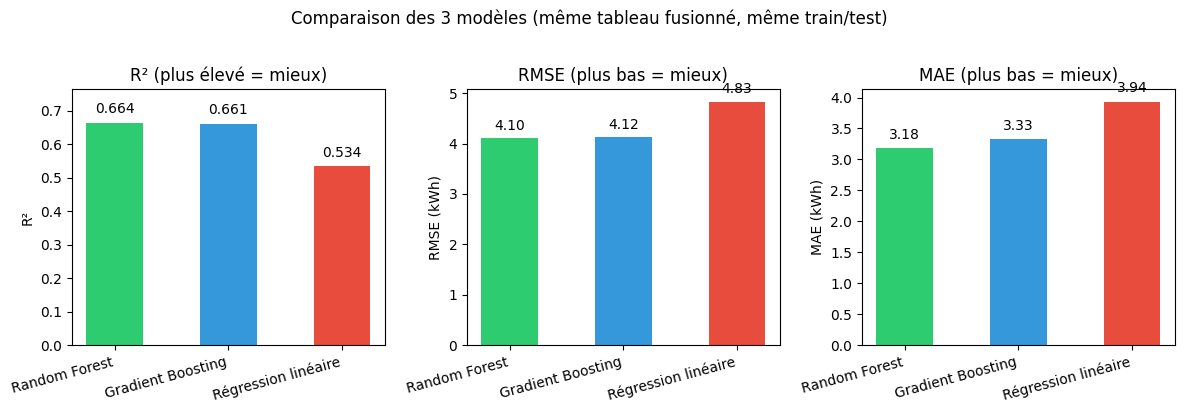


Récapitulatif :
             Modèle     R²  RMSE (kWh)  MAE (kWh)
      Random Forest 0.6643        4.10       3.18
  Gradient Boosting 0.6611        4.12       3.33
Régression linéaire 0.5343        4.83       3.94


In [41]:
# =============================================================================
# Comparaison R², RMSE et MAE entre les 3 modèles
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

modeles = ["Random Forest", "Gradient Boosting", "Régression linéaire"]
r2_vals = [r2_f, r2_gb, r2_lr]
rmse_vals = [rmse_f, rmse_gb, rmse_lr]
mae_vals = [mae_f, mae_gb, mae_lr]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
x = np.arange(len(modeles))
width = 0.5
colors = ["#2ecc71", "#3498db", "#e74c3c"]

# 1. R² (plus élevé = mieux)
axes[0].bar(x, r2_vals, width, color=colors)
axes[0].set_ylabel("R²")
axes[0].set_title("R² (plus élevé = mieux)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(modeles, rotation=15, ha="right")
axes[0].set_ylim(0, max(r2_vals) * 1.15 if max(r2_vals) > 0 else 1)
for i, v in enumerate(r2_vals):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=10)

# 2. RMSE (kWh) (plus bas = mieux)
axes[1].bar(x, rmse_vals, width, color=colors)
axes[1].set_ylabel("RMSE (kWh)")
axes[1].set_title("RMSE (plus bas = mieux)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(modeles, rotation=15, ha="right")
for i, v in enumerate(rmse_vals):
    axes[1].text(i, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# 3. MAE (kWh) (plus bas = mieux)
axes[2].bar(x, mae_vals, width, color=colors)
axes[2].set_ylabel("MAE (kWh)")
axes[2].set_title("MAE (plus bas = mieux)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(modeles, rotation=15, ha="right")
for i, v in enumerate(mae_vals):
    axes[2].text(i, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

plt.suptitle("Comparaison des 3 modèles (même tableau fusionné, même train/test)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Tableau récapitulatif
comparison_df = pd.DataFrame({
    "Modèle": modeles,
    "R²": [round(v, 4) for v in r2_vals],
    "RMSE (kWh)": [round(v, 2) for v in rmse_vals],
    "MAE (kWh)": [round(v, 2) for v in mae_vals],
})
print("\nRécapitulatif :")
print(comparison_df.to_string(index=False))